In [ ]:
# default_exp load_data
# %reload_ext autoreload
# %autoreload 2
from nbdev.showdoc import show_doc
!date

Fri May  6 12:44:28 PDT 2022


# Load data
> Prepare photons and exposure, given a source 

This module defines the function `load_source_data`.

Depends on module Exposure for SC data 

In [ ]:
#export
import pickle, healpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from wtlike.config import (Config, UTC, MJD)
from wtlike.exposure import  binned_exposure, sc_data_selection, sc_process, weighted_aeff #KerrAeff, SourceAeff
from wtlike.data_man import get_week_files


In [ ]:
# exporti
class ConeSelect():
    """Manage selection of pixels with cone
    
    """
    
    def __init__(self, config, l,b):

        cart = lambda l,b: healpy.dir2vec(l,b, lonlat=True)
        self.conepix = healpy.query_disc(config.nside, cart(l,b), np.radians(config.radius), nest=config.nest)
        
    def __call__(self, pixels, shift=11):
        """
        For a set of pixels, return a mask for the cone
        """
        # select by comparing high-order pixels (faster)
        a = np.right_shift(pixels, shift)
        c = np.unique(np.right_shift(self.conepix, shift))
        return np.isin(a,c)

In [ ]:
#hide
ds = ConeSelect(Config(), 0,0)
assert np.all(ds(ds.conepix))==True

sum(ds(np.arange(int(12*1024**2))))


36864

In [ ]:
# exporti        
        
def _get_photons_near_source(config, source, week): #tzero, photon_df):
    """
    Select the photons near a source

    - source : a PointSource object
    - week : dict with
        - tzero : start time for the photon
        - photons : dict with photon data
        - runlist : list of run numbers

    Returns a DF with
    - `band` index,
    - `time` in MJD (added tstart and converted from MET)
    - `pixel` index, nest indexing
    - `radius` distance in deg from source direction
    """

    def _cone(config, source, nest=True):
        # cone geometry stuff: get corresponding pixels and center vector
        l,b,radius = source.l, source.b, config.radius
        cart = lambda l,b: healpy.dir2vec(l,b, lonlat=True)
        conepix = healpy.query_disc(config.nside, cart(l,b), np.radians(radius), nest=nest)
        center = healpy.dir2vec(l,b, lonlat=True)
        return center, conepix

    center, conepix = _cone(config,source)

    df = pd.DataFrame.from_dict(week['photons'])
    
    tstart = week['tstart']
    allpix = df.nest_index.values

    # select by comparing high-order pixels (faster)
    shift=11
    a = np.right_shift(allpix, shift)
    c = np.unique(np.right_shift(conepix, shift))
    incone = np.isin(a,c)

    if sum(incone)<2:
        if config.verbose>1:
            print(f'\nWeek starting {UTC(MJD(tstart))} has 0 or 1 photons')
        return

    if config.verbose>2:
        a, b = sum(incone), len(allpix)
        print(f'Select photons for source {source.name}:\n\tPixel cone cut: select {a} from {b} ({100*a/b:.1f}%)')

    # cut df to entries in the cone
    dfc = df[incone].copy()

    # assemble the DataFrame, remove those outside the radius
    out_df = dfc

    # make sure times are monotonic by sorting (needed since runs not in order in most
    #  week-files after March 2018)
    # out_df = dfc.sort_values(by='time')

    if config.verbose>2:
        print(f'selected photons:\n{out_df.head()}')

    return out_df

In [ ]:
# export
def sc_data_selection(config, source, sc_data):

    """
    Return a DataFrame with the S/C data for the source direction, wtih cos theta and zenith cuts

    columns:
    - start, stop, livetime -- from the FT2 info
    - cos_theta -- angle between bore and direction
    - exp -- the exposure: effective area at angle weighted by a default spectral function, times livetime

    """

    sc_df = sc_process(config, source, sc_data)
    if len(sc_df)==0:
        return sc_df
    cos_theta = sc_df.cos_theta.values
    livetime = sc_df.livetime.values
    func = weighted_aeff(config, source) 
    
    sc_df.loc[:,'exp'] = exp = (func(cos_theta) * livetime).astype(np.float32)
    
    # add detailed exposure info, the fraction of the total in each band
    if config.get('full_exp', False):
        A,L = func.binned(cos_theta), livetime
        fract = ((A.T * L/exp).T ).astype(np.float16)
        sc_df.loc[:,'exp_fract' ] = [list(x) for x in fract]
    
    return sc_df

In [ ]:
show_doc(sc_data_selection)

<h4 id="sc_data_selection" class="doc_header"><code>sc_data_selection</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>sc_data_selection</code>(**`config`**, **`source`**, **`sc_data`**)

Return a DataFrame with the S/C data for the source direction, wtih cos theta and zenith cuts

columns:
- start, stop, livetime -- from the FT2 info
- cos_theta -- angle between bore and direction
- exp -- the exposure: effective area at angle weighted by a default spectral function, times livetime

In [ ]:
# hide
def cumsimpson(u, dx):
    """Return the cumulative Simpson integral for an odd number>4 of equally-spaced evaluations
     * u -- array of integrad values, 2n+1 values for 2n intervals
     * dx -- interval size
     
     Returns array of size n, the cumulative integral estimate for pairs of intervals
     
     >> x = np.linspace(0,1, 5)
     >> print(cumsimpson(x, 1/4)) 
     >> [0.125 0.5  ]
    """
    v = np.empty((3*(len(u)-1)//2))
    v[0::3] = u[0:-1:2]
    v[1::3] = 4*u[1::2]
    v[2::3] = u[2::2]
    return (np.cumsum(v)*dx/3)[2::3]


In [ ]:
# exporti
class ProcessWeek(object):
    """
    Process a week's photon and livetime info into the source-related photon and exposure tables.   
    """
  
    def __init__(self, config, source, week_file): 
        """
        
        """
        with open(week_file, 'rb') as inp:
            week = pickle.load(inp)
            
        # convert the photon and spacecraft dicts to DataFrames
        pdf = pd.DataFrame(week['photons'])
        sc_data = edf = pd.DataFrame.from_dict(week['sc_data'])
        self.runlist = week.get('runlist', None)
        self.start = MJD(week['tstart'])
        self.config = config

        if config.verbose>1:
            print(f'Opened week file "{week_file.name}" of {UTC(self.start)}')
            print(f'\tFound {len(pdf):,} photons, {len(edf):,} SC entries)')
        
        self.sc_df = sc_df = sc_data_selection(config, source, sc_data)
        
        # interleaved start/stop 
        self.stime = np.empty(2*len(sc_df.start))
        self.stime[0::2]=sc_df.start.values
        self.stime[1::2]=sc_df.stop.values
        assert np.all(np.diff(self.stime)>=0), 'Time-ordering failure'

        self.lt = sc_df.livetime.values
        self.ct = sc_df.cos_theta.values
        

        pdf = _get_photons_near_source(config,source, week)
        if pdf is None or len(pdf)<3 :
            self.photons = None
        else:
            assert pdf is not None and len(pdf)>0
            
            # set weights from the weight table, removing those with no weight            
            pdf = source.wtman.add_weights(pdf)
            
            # finally set the time and the exposure per remaining photons
            self.photons = self.photon_times( pdf )
            
    def __str__(self):
        return f'Data for week of {UTC(self.start)}: {len(self.photons):,} photons'
    
    def __repr__(self): return self.__str__()
        
    def photon_times(self, pdf):
        
        # construct the time from the run number and offset
        if  'run_id' in pdf: run = pdf.run_id.astype(float)
        elif 'run_ref' in pdf: run = self.runlist[pdf.run_ref]
        else:
            raise Exception('Expect run_id or run_ref')
        ptime = MJD(run + pdf.trun * self.config.offset_size)
        pdf.loc[:,'time'] = ptime

        # select the subset with exposure info
        tk = np.searchsorted(self.stime, ptime)
        good_exp = np.mod(tk,2)==1
        pdfg = pdf[good_exp].copy()
        if len(pdfg)==0:
            return None
        pdfg.drop(columns=['trun'], inplace=True)
        # time edges-- same for each band
        #xp = np.append(self.stime[0::2],self.stime[-1]) 
        
        return pdfg
    
    def hist_spacecraft(self):
        self.sc_df.hist('livetime cos_theta exp'.split(), bins=100, layout=(1,3), figsize=(12,3));
        
    def hist_photons(self):
        self.photons.hist('band time'.split(), bins=100, log=True, figsize=(12,3), layout=(1,3));
        
       
    def __call__(self):
        return dict(
            start= self.start,
            photons=self.photons, 
            exposure=self.sc_df,

        )

In [ ]:
#exporti
class TWeek():
    # This is a funtcor wrapping ProcessWeek needed to be global. 
    def __init__(self, config, source):
        self.config=config
        self.source=source
        
    def __call__(self, wkf):
        print('.', end='')
        eman = ProcessWeek( self.config, self.source, wkf)
        return (eman.photons, eman.sc_df)
    
def multiprocess_week_data(config, source, week_range, processes=None):
    """ Manage processing of set of week files with multiprocessing
    """
    
    from multiprocessing import Pool
    
    processes = processes or config.pool_size
    week_files = get_week_files(config,  week_range) 
    txt = f', using {processes} processes ' if processes>1 else ''
    
    if config.verbose>0:
        print(f'\tProcessing {len(week_files)} week files {week_files[0].name} - {week_files[-1].name} {txt}', end='', flush=True)
    
    process_week = TWeek(config, source)
    
    if processes>1:
        with Pool(processes=processes) as pool:
            week_data = pool.map(process_week, week_files)
    else:
        week_data = map(process_week,  week_files)
    print('\n')
    
    pp = []
    ee = []

    for wk in week_data:
        # append week data to photons, weighted exposure, band exposure
        pdf,edf = wk
        if pdf is not None and len(pdf)>2:
            pp.append(pdf)
        if len(edf)>0:
            ee.append(edf)

    return pp,ee

In [ ]:
#export
def load_source_data(config, source, week_range=None, key='', clear=False):
    """
    Generate photon and exposure tables specific to the source. 
    
    - week_range [None] -- if None, select all weeks
    - key ['']   -- key to use for cache, construct from name if not set      
    - clear [False]
    
    For the given source returns a tuple of
    - photons
    - exposure
    - the key 

    """

    if config.datapath/'data_files' is None and key not in config.cache:
        raise Exception(f'Data for {source.name} is not cached, and config.datapath/"data_files" is not set')

    def load_from_weekly_data(config, source, week_range=None):
        
        pp, ee =  multiprocess_week_data(config, source, week_range)
        
        # concatenate the two lists of DataFrames
        p_df = pd.concat(pp, ignore_index=True)
        #p_df.loc[:,'run_id'] = pd.Categorical(p_df.run_id)
        e_df = pd.concat(ee, ignore_index=True)

        return p_df, e_df
    
    description=f'SourceData:  {source.name}'
    
    used_key = None # change if used cache
    if week_range is not None or key is None:
        # always load directly if weeks specified or key set to None
        print(description)
        r = load_from_weekly_data(config, source, week_range=week_range)
    else:
        # use the cache
        used_key = f'{source.filename}_data' if key=='' else key
        r = config.cache(used_key,
                    load_from_weekly_data, config, source, week_range=None,
                    overwrite=clear,
                    description=description)
    # append key used for retrieval
    return list(r) + [used_key]

In [ ]:
show_doc(load_source_data, title_level=2)

<h2 id="load_source_data" class="doc_header"><code>load_source_data</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h2>

> <code>load_source_data</code>(**`config`**, **`source`**, **`week_range`**=*`None`*, **`key`**=*`''`*, **`clear`**=*`False`*)

Generate photon and exposure tables specific to the source. 

- week_range [None] -- if None, select all weeks
- key ['']   -- key to use for cache, construct from name if not set      
- clear [False]

For the given source returns a tuple of
- photons
- exposure
- the key 

### Cache update
If the most recent week has been changed, load it and replace only the most recent part in the cache.

Develop/test with Geminga

### Test multiprocessing

In [ ]:
# #hide
from wtlike.sources import PointSource
from wtlike.config import Timer
config=Config(); 
if config.valid:
    test_weeks = (9,108)
    source =PointSource('Geminga', config=config) 
    with Timer() as t1:
        config.pool_size=processes=4
        sd1 = load_source_data(config, source, week_range=test_weeks, key=None )
    print(t1)
    with Timer() as t2:
        config.pool_size=1
        sd2 = load_source_data(config, source, week_range=test_weeks, key=None )
    print(t2)
    print(f'Timing ratio using {processes} proceses: {t2.elapsed/t1.elapsed:.2f}')
    assert( len(sd1[0])==len(sd2[0]) ), 'Fail multiprocessing test'

SourceData:  PSR J0633+1746
	Processing 100 week files week_009.pkl - week_108.pkl , using 4 processes ....................................................................................................

elapsed time: 33.2s (0.6 min)
SourceData:  PSR J0633+1746
	Processing 100 week files week_009.pkl - week_108.pkl 

....................................................................................................elapsed time: 88.2s (1.5 min)
Timing ratio using 4 proceses: 2.66


#### Test with a Geminga week

WeightMan: file from source "PSR J0633+1746"_weights.pkl : 16 bamds with nsides 64 to 512
LoadData: Loading weeks[720:720:]
Opened week file "week_720.pkl" of 2022-03-17 01:00
	Found 370,917 photons, 17,324 SC entries)
	Found 17,324 S/C entries:  4,805 remain after zenith and theta cuts
WeightMan: processing 2,215 photons
	remove 947 events without weight


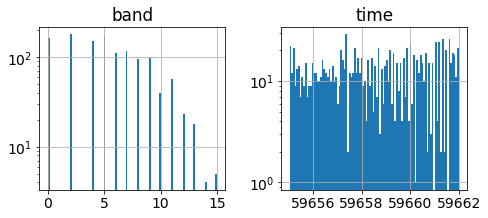

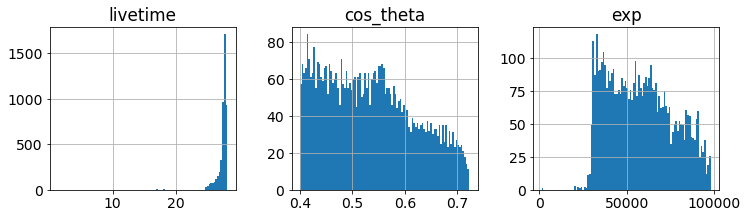

In [ ]:
#hide
config=Config(full_exp=True,verbose=2)
name="Geminga"
# name='PSR B1259-63'
week=720 #725
if config.valid:
    # testing
    from wtlike.sources import PointSource
    source =PointSource(name, config=config) 
    week_files = get_week_files(config, week); 
    week_file = week_files[0]
    self = ProcessWeek(config, source, week_file)

    self.hist_photons()
    self.hist_spacecraft()

Opened week file "week_720.pkl" of 2022-03-17 01:00
	Found 370,917 photons, 17,324 SC entries)
	Found 17,324 S/C entries:  4,805 remain after zenith and theta cuts
WeightMan: processing 2,215 photons
	remove 947 events without weight


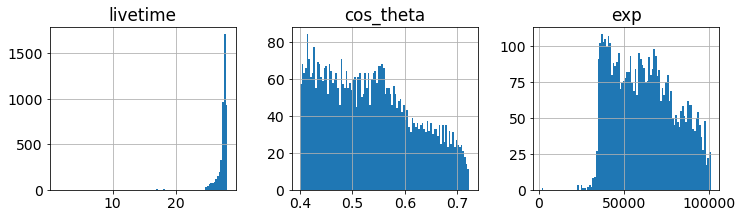

In [ ]:
# hide
config.use_kerr=False
nk = ProcessWeek(config, source, week_file)
nk.hist_spacecraft()

### Look at the ratio of Geminga exposures vs. $\cos\theta$.

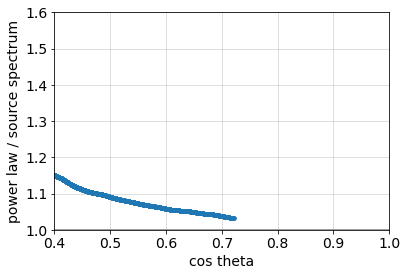

In [ ]:
expratio = nk.sc_df.exp/self.sc_df.exp
ax = plt.gca()
ax.plot(self.sc_df.cos_theta, expratio, '.');
ax.grid(alpha=0.5); ax.set(xlabel='cos theta', ylabel='power law / source spectrum',
                           xlim=(0.4,1), ylim=(1.0, 1.6) );
ax.axhline(1,color='grey');

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()
!date

Converted 00_config.ipynb.
Converted 01_data_man.ipynb.
Converted 02_effective_area.ipynb.
Converted 03_exposure.ipynb.
Converted 03_sources.ipynb.
Converted 04_load_data.ipynb.
Converted 04_simulation.ipynb.
Converted 05_source_data.ipynb.
Converted 06_poisson.ipynb.
Converted 07_loglike.ipynb.
Converted 08_cell_data.ipynb.
Converted 09_lightcurve.ipynb.
Converted 10-time_series.ipynb.
Converted 14_bayesian.ipynb.
Converted 90_main.ipynb.
Converted 99_presentation.ipynb.
Converted 99_tutorial.ipynb.
Converted index.ipynb.
Fri May  6 12:46:59 PDT 2022
